<p style="font-size:20px;">Simulator: QiskitAer, FakeTorino, ideal device noise simulator (no shot noise). H4 (rectangular) in minimal basis (STO-3G), JW mapping, 3-layered tUPS. With 40 samples generated randomly, number of parameters is 27, number of non Clifford parameters k = 3. Fitting methods: Square regression with a linear ansatz, Nonlinear Fitting, XGB, MLP.</p>

In [4]:
import pyscf
import slowquant.SlowQuant as sq
from qiskit_nature.second_q.mappers import JordanWignerMapper
from slowquant.qiskit_interface.interface import QuantumInterface
from slowquant.qiskit_interface.wavefunction import WaveFunction
#from slowquant.qiskit_interface.linear_response.projected import quantumLR

from qiskit_ibm_runtime.fake_provider import FakeTorino

from qiskit.primitives import Estimator

from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_aer.primitives import Sampler
from qiskit_aer.primitives import SamplerV2

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

import numpy as np
from scipy.optimize import minimize
from scipy.optimize import curve_fit
import random

from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import time

In [3]:
mol = pyscf.M(atom="""H 0.0 0.0 0.0;
                      H 1.5 0.0 0.0;
                      H 0.0 1.8 0.0;
                      H 1.5 1.8 0.0;""", basis="sto-3g", unit="angstrom")
rhf = pyscf.scf.RHF(mol).run()

sampler = Estimator()
primitive = sampler
mapper = JordanWignerMapper()
# For H4 you can make the wavefunction better by increasing n_layers.
# n_layers: 3 will prob. give almost the FCI solution.
QI = QuantumInterface(primitive, "tUPS", mapper, ansatz_options={"n_layers": 3, "do_pp": True}, ISA = True)

WF = WaveFunction(
    mol.nao * 2,
    mol.nelectron,
    (4, 4),
    rhf.mo_coeff,
    mol.intor("int1e_kin") + mol.intor("int1e_nuc"),
    mol.intor("int2e"),
    QI,
    #include_active_kappa = True
)

#WF.run_vqe_2step("RotoSolve", maxiter=3)
#WF.run_vqe_2step("SLSQP", maxiter=40)
WF.ansatz_parameters = [3.142800380570141, 2.802123553483023, 3.141844220036336, 3.1415016877195234, 2.7699109323169533, 3.140289037489865, 1.5722892785591813, -0.05183267369041262, -3.139930460730367, -3.05193091891377, 0.07499512879186974, 0.26977250393898994, -2.875485939584386, -0.18478422435886988, 0.21835082743355141, -3.145279642647945, 0.2027868009455131, 3.141049426792193, -2.802097303067954, -0.20245039509840054, 0.14415193008627167, 0.24779481988227897, -0.04867618752527981, -3.0111535837495227, -3.1367777510378136, -0.21605050555915123, -3.14472880076259]

#no noise
nonclif_ground_state_energy = WF.energy_elec
print("Non-Clifford Ground state energy:", nonclif_ground_state_energy)

#device noise
# Update the primitive with simulated noise
backend = FakeTorino()
QI.pass_manager = generate_preset_pass_manager(3,backend=backend,seed_transpiler=123) # seeded standard transpiler
QI.do_postselection = False
QI.do_M_mitigation = False
noise_model = NoiseModel.from_backend(backend)
sampler = Sampler(backend_options={"noise_model":noise_model})
WF.change_primitive(sampler)    
# Calculate the ground state energy using the noisy simulator
noisy_nonclif_ground_state_energy = WF.energy_elec
print("Noisy Non-Clifford Ground state energy:",noisy_nonclif_ground_state_energy)

converged SCF energy = -1.77674731624872
Number of shots is None. Ideal simulator is assumed.
You selected ISA but did not pass a PassManager. Standard internal transpilation will use backend None with optimization level 3


/tmp/ipykernel_2269012/1838215017.py:7: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  sampler = Estimator()


Non-Clifford Ground state energy: -3.712497370567829
Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 Post-processing:     False
 Circuit layout:      [17, 25, 35, 24, 28, 26, 27, 44]
 Non-local gates:     405
 Transpilation strategy: External PassManager
 Primitive backend:   AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['sx', 'cz', 'x', 'reset', 'id', 'measure']>)

Noisy Non-Clifford Ground state energy: -2.9354609200029995


In [5]:
print(WF.ansatz_parameters)

[3.142800380570141, 2.802123553483023, 3.141844220036336, 3.1415016877195234, 2.7699109323169533, 3.140289037489865, 1.5722892785591813, -0.05183267369041262, -3.139930460730367, -3.05193091891377, 0.07499512879186974, 0.26977250393898994, -2.875485939584386, -0.18478422435886988, 0.21835082743355141, -3.145279642647945, 0.2027868009455131, 3.141049426792193, -2.802097303067954, -0.20245039509840054, 0.14415193008627167, 0.24779481988227897, -0.04867618752527981, -3.0111535837495227, -3.1367777510378136, -0.21605050555915123, -3.14472880076259]


In [5]:
#prepare training set
clif_ground_state_energies = []
noisy_clif_ground_state_energies = []
results_linear = []
results_nonlinear = []
results_xgb = []
results_mlp = []
times = []
i = 12

for k in range(i):
    n_replacements = k + 1
    start_time = time.time()
    for n in range(30):
        QI = QuantumInterface(primitive, "tUPS", mapper, ansatz_options={"n_layers": 3, "do_pp": True}, ISA = True)

        WF = WaveFunction(
        mol.nao * 2,
        mol.nelectron,
        (4, 4),
        rhf.mo_coeff,
        mol.intor("int1e_kin") + mol.intor("int1e_nuc"),
        mol.intor("int2e"),
        QI,
        #include_active_kappa = True
        )

        indices_to_replace = random.sample(range(len(WF.ansatz_parameters)), n_replacements)
        for index in indices_to_replace:
            WF.ansatz_parameters[index] = random.uniform(0, 2*np.pi)
        print(WF.ansatz_parameters)

        clif_ground_state_energy = WF.energy_elec
        clif_ground_state_energies.append(clif_ground_state_energy)
        
        backend = FakeTorino()
        QI.pass_manager = generate_preset_pass_manager(3,backend=backend,seed_transpiler=123) # seeded standard transpiler
        QI.do_postselection = False
        QI.do_M_mitigation = False
        noise_model = NoiseModel.from_backend(backend)
        sampler = Sampler(backend_options={"noise_model":noise_model})
        WF.change_primitive(sampler)   
        noisy_clif_ground_state_energy = WF.energy_elec
        noisy_clif_ground_state_energies.append(noisy_clif_ground_state_energy)

    end_time = time.time()
    elapsed_time = end_time - start_time
    times.append(elapsed_time)
    
    #data preparation
    nonclif_ground_state_energies = [nonclif_ground_state_energy for _ in range(len(clif_ground_state_energies))]
    noisy_nonclif_ground_state_energies = [noisy_nonclif_ground_state_energy for _ in range(len(noisy_clif_ground_state_energies))]
    X = np.array(noisy_clif_ground_state_energies).reshape(-1, 1)
    y = np.array(clif_ground_state_energies)
    X_test = np.array(noisy_nonclif_ground_state_energies).reshape(-1, 1)
    y_test = np.array(nonclif_ground_state_energies)

    #square regression with a linear ansatz
    def cost_function(a, X_exact, X_noisy):
        a1, a2 = a  # 将参数 a 拆分为 a1 和 a2
        # 计算代价函数 C 的值
        C = np.sum((X_exact - (a1 * X_noisy + a2))**2)
        return C
    X_exact = np.array(clif_ground_state_energies)
    X_noisy = np.array(noisy_clif_ground_state_energies)
    # 初始猜测值 a1 和 a2
    initial_guess = [1, 0]
    # 最小化代价函数
    result = minimize(cost_function, initial_guess, args=(X_exact, X_noisy))
    # 得到最优的 a1 和 a2
    a1_optimal, a2_optimal = result.x
    #print(f"最优的 a1 值: {a1_optimal}")
    #print(f"最优的 a2 值: {a2_optimal}")
    y_pred_linear = a1_optimal*noisy_nonclif_ground_state_energy + a2_optimal
    print('result of square regression:', y_pred_linear)
    results_linear.append(y_pred_linear)

    #Nonlinear Fitting
    # 定义非线性拟合函数
    def nonlinear_model(X_noisy, a1, a2, a3):
        return a1 * X_noisy**2 + a2 * X_noisy + a3
    # 输入数据
    X_exact = np.array(clif_ground_state_energies)
    X_noisy = np.array(noisy_clif_ground_state_energies)
    # 使用 curve_fit 进行非线性拟合
    # 初始猜测值 [a1, a2, a3]
    initial_guess = [1, 1, 0]
    params, covariance = curve_fit(nonlinear_model, X_noisy, X_exact, p0=initial_guess)
    # 提取拟合参数
    a1_optimal, a2_optimal, a3_optimal = params
    #print(f"最优的 a1 值: {a1_optimal}")
    #print(f"最优的 a2 值: {a2_optimal}")
    #print(f"最优的 a3 值: {a3_optimal}")
    #对新的数据进行预测
    y_pred_nonlinear = nonlinear_model(noisy_nonclif_ground_state_energy, a1_optimal, a2_optimal, a3_optimal)
    print('Result of Nonlinear Fitting:', y_pred_nonlinear)
    results_nonlinear.append(y_pred_nonlinear)

    #XGBoost
    xgb_model = XGBRegressor(max_depth=20, eta=0.0005, subsample=0.7, colsample_bytree=0.7, objective='reg:absoluteerror', n_estimators=1000, random_state=42)
    xgb_model.fit(X, y)
    y_pred_xgb = xgb_model.predict(X_test)
    # 计算均方误差
    #mse_corrected_XGB = mean_squared_error(y_test, y_pred_xgb)
    #print('mse:', mse_corrected_XGB)
    print('result of xgb:', y_pred_xgb[0])
    results_xgb.append(y_pred_xgb[0])

    #MLP
    # 归一化数据
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    # 训练MLP模型
    mlp_model = MLPRegressor(hidden_layer_sizes=(120, 60), activation='relu', solver='adam', max_iter=2000, alpha=0.001, random_state=42)
    mlp_model.fit(X_scaled, y)
    X_test_scaled = scaler.transform(X_test)
    y_pred_mlp = mlp_model.predict(X_test_scaled)
    #mse_corrected_MLP = mean_squared_error(y_test, y_pred_mlp)
    #print('mse:', mse_corrected_MLP)
    print('result of mlp:', y_pred_mlp[0])
    results_mlp.append(y_pred_mlp[0])

Number of shots is None. Ideal simulator is assumed.
You selected ISA but did not pass a PassManager. Standard internal transpilation will use backend None with optimization level 3
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.515787738729887]
Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 Post-processing:     False
 Circuit layout:      [17, 25, 35, 24, 28, 26, 27, 44]
 Non-local gates:     405
 Transpilation strategy: External PassManager
 Primitive backend:   AerSimulator('ae

In [6]:
print(times)

[714.3629539012909, 684.4337575435638, 690.1352622509003, 677.3652729988098, 668.3757162094116, 668.498126745224, 666.0504109859467, 667.6078593730927, 668.5961632728577, 667.2301406860352, 671.023295879364, 670.6064260005951]


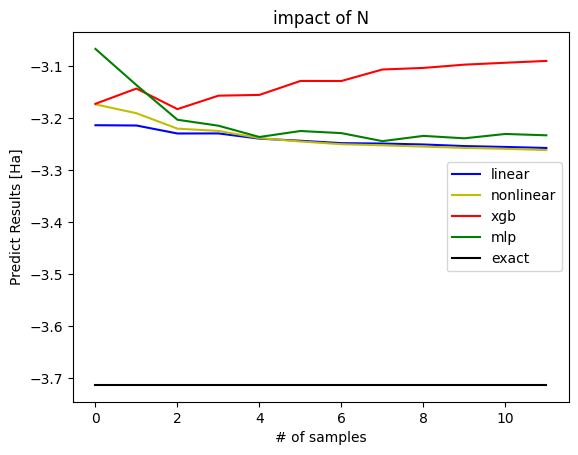

In [7]:
exact = [nonclif_ground_state_energy for _ in range(i)]
# 绘制折线图
plt.plot(results_linear, marker='None', linestyle='-', color='b', label='linear')
plt.plot(results_nonlinear, marker='None', linestyle='-', color='y', label='nonlinear')
plt.plot(results_xgb, marker='None', linestyle='-', color='r', label='xgb')
plt.plot(results_mlp, marker='None', linestyle='-', color='g', label='mlp')
plt.plot(exact, marker='None', linestyle='-', color='k', label='exact')
# 限制 y 轴范围
#plt.ylim(-3.8, -3)
# 添加标题和标签
plt.title("impact of N")
plt.xlabel("# of samples")
plt.ylabel("Predict Results [Ha]")

# 添加网格
#plt.grid(True, linestyle='--', alpha=0.6)

# 显示图例
plt.legend()

# 显示图像
plt.show()

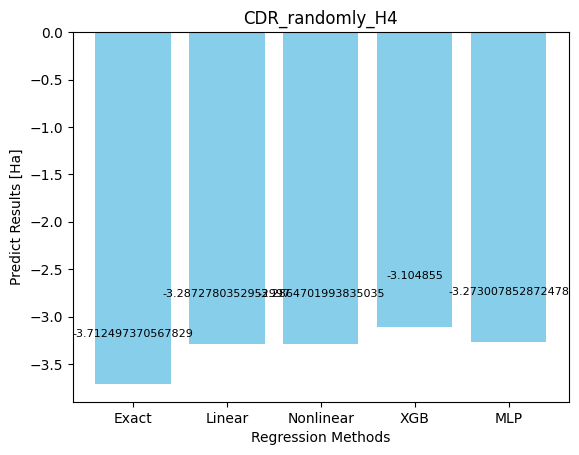

In [24]:
# 数据
categories = ['Exact', 'Linear', 'Nonlinear', 'XGB', 'MLP']
values = [nonclif_ground_state_energy, y_pred_linear, y_pred_nonlinear, y_pred_xgb[0], y_pred_mlp[0]]

# 绘制柱状图
plt.bar(categories, values, color='skyblue')

# 添加标题和标签
plt.title('CDR_randomly_H4')
plt.xlabel('Regression Methods')
plt.ylabel('Predict Results [Ha]')

# 在每个柱子上标注数值
for i, v in enumerate(values):
    plt.text(i, v + 0.5, str(v), ha='center', fontsize=8)

# 显示图表
plt.show()